In [67]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.path as mpath
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
#from xgcm import Grid
import requests
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import glob, os

import dask.array as da
from dask.diagnostics import ProgressBar

In [68]:
col_height = xr.open_dataset(f'Data_Step2/control/col_height.nc').rename({'yh':'lat', 'xh':'lon'})['col_height']

# Ensure that longitude coords are from -180 to 180
col_height.coords['lon'] = (col_height.coords['lon'] + 180) % 360 - 180
col_height = col_height.sortby(col_height.lon)

In [69]:
umo = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_piControl_c192_OM4p25_v8/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_monthly_z/ts/monthly/5yr/ocean_monthly_z.035601-036012.umo.nc')['umo'].compute()
umo = umo.rename({'yh':'lat', 'xq':'lon'})

In [70]:
umo.coords['lon'] = (umo.coords['lon'] + 180) % 360 - 180
umo = umo.sortby(umo.lon)

In [71]:
umo

<xarray.DataArray 'umo' (time: 60, z_l: 35, lat: 1080, lon: 1441)>
array([[[[         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         ...,
         [-1758676.   ,  -821688.94 ,   911024.9  , ..., -1733771.4  ,
          -1977427.8  , -2085281.1  ],
         [-2008563.8  ,  -991146.7  ,   950485.8  , ..., -1756155.   ,
          -2579094.2  , -2437177.   ],
         [-1924941.1  ,  -901002.06 ,  1211604.8  , ..., -2139885.8  ,
          -2365744.2  , -2412259.   ]],

        [[         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
...
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan]],

        [[         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         ...,
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan]]]], dtype=float32)
Coordinates:
  * time     (time) object 0356-01-16 12:00:00 ... 0360-12-16 12:00:00
  * lon      (lon) float64 -179.8 -179.5 -179.3 -179.0 ... 179.5 179.7 180.0
  * lat      (lat) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
  * z_l      (z_l) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
Attributes:
    long_name:      Ocean Mass X Transport
    units:          kg s-1
    cell_methods:   z_l:sum yh:sum xq:point time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  ocean_mass_x_transport
    interp_method:  none

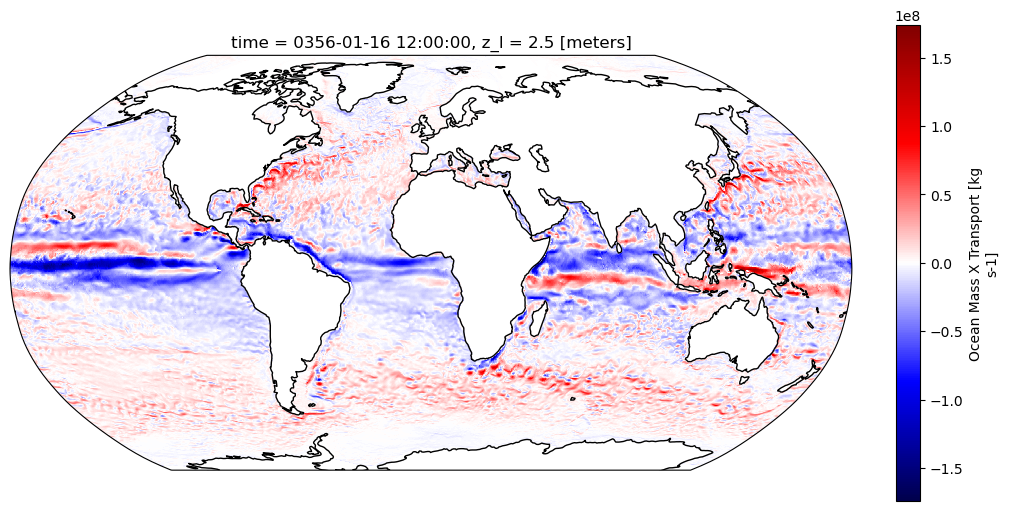

In [72]:
fig, axes = plt.subplots(1, 1, subplot_kw={'projection':ccrs.Robinson()}, figsize=(10,5), constrained_layout=True)
umo.isel(z_l=0).isel(time=0).plot(ax=axes, transform=ccrs.PlateCarree(), cmap='seismic')
axes.coastlines()
plt.show()

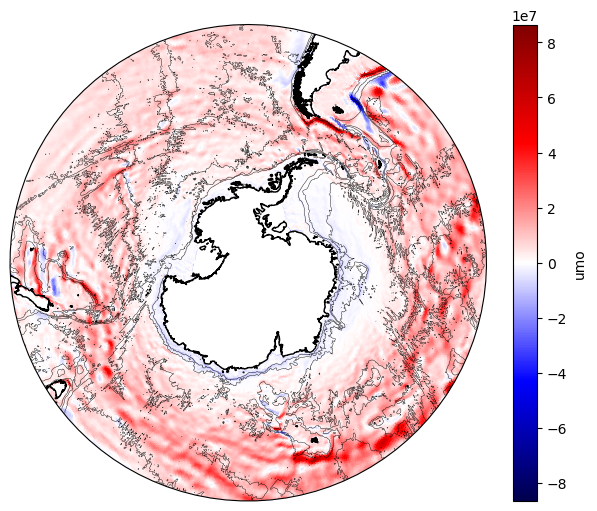

In [73]:
fig, axes = plt.subplots(1, 1, subplot_kw={'projection':ccrs.SouthPolarStereo(central_longitude=-90)},
                         figsize=(6,5), constrained_layout=True)

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

umo.mean('time').isel(z_l=0).sel(lat=slice(-90,-40)).plot(ax=axes, transform=ccrs.PlateCarree(), cmap='seismic')

xr.plot.contour(col_height.sel(lat=slice(-90,-40)), ax=axes,
                transform=ccrs.PlateCarree(), colors='black', linewidths=0.3)

axes.coastlines(resolution='10m')
axes.set_boundary(circle, transform=axes.transAxes)

plt.show()

In [74]:
experiment = 'ssp585'
var = 'umo'

In [75]:
if experiment == 'control':
    path='/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_piControl_c192_OM4p25_v8/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_monthly_z/ts/monthly/5yr/'
    ds_grid=xr.open_dataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_piControl_c192_OM4p25_v8/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_monthly_z/ocean_monthly_z.static.nc')
elif experiment == 'historical':
    path='/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_historical_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_monthly_z/ts/monthly/5yr/'
    ds_grid=xr.open_dataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_historical_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_monthly_z/ocean_monthly_z.static.nc')
elif experiment == 'ssp585':
    path='/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_ssp585_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_monthly_z/ts/monthly/5yr/'
    ds_grid=xr.open_dataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_ssp585_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_monthly_z/ocean_monthly_z.static.nc')

dsShortGrid=ds_grid.isel(xq=np.arange(1,1441)).isel(yq=np.arange(1,1081))

In [76]:
test=glob.glob(path + 'ocean_monthly_z.*.umo.nc')
test[0][159:172]

'202501-202912'

In [77]:
test=glob.glob(path + 'ocean_monthly_z.*.umo.nc')

if experiment == 'control':
    year_name_start_idx, year_name_end_idx = 165, 178
elif experiment == 'historical':
    year_name_start_idx, year_name_end_idx = 163, 176
elif experiment == 'ssp585':
    year_name_start_idx, year_name_end_idx = 159, 172

one=test[0]
times=[one[year_name_start_idx:year_name_end_idx]]

for tt in np.arange(1,len(test)): 
    one=test[tt]
    times=times+[one[year_name_start_idx:year_name_end_idx]]
    
times = sorted(times)

if experiment == 'control':
    pass
elif experiment == 'historical':
    times = times[-5:]
elif experiment == 'ssp585':
    times = times[-4:]
    #times = times[-12:-8]

times

['208001-208412', '208501-208912', '209001-209412', '209501-209912']

In [78]:
datasets = []

if experiment == 'control':
    pass
elif experiment == 'historical':
    start_yr, end_yr = '1992', '2013'
elif experiment == 'ssp585':
    pass

files = [f'{path}/ocean_monthly_z.{time}.{var}.nc' for time in times]

print('Gathering dataset...')
ds = xr.open_mfdataset(files, chunks={"time": 12}, parallel=True)
with ProgressBar():
    ds = ds.compute()
    
datasets.append(ds)
    
#datasets.append(ds_grid)

print('Merging datasets...')
if experiment == 'control':
    full_ds = xr.merge(datasets).compute()
elif experiment == 'historical':
    full_ds = xr.merge(datasets).sel(time=slice(start_yr, end_yr)).compute()
elif experiment == 'ssp585':
    full_ds = xr.merge(datasets).compute()

full_ds

Gathering dataset...
[########################################] | 100% Completed | 239.28 s
Merging datasets...


<xarray.Dataset>
Dimensions:     (time: 240, nv: 2, z_l: 35, yh: 1080, xq: 1441, z_i: 36)
Coordinates:
  * nv          (nv) float64 1.0 2.0
  * time        (time) object 2080-01-16 12:00:00 ... 2099-12-16 12:00:00
  * xq          (xq) float64 -299.8 -299.6 -299.3 -299.1 ... 59.66 59.91 60.16
  * yh          (yh) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
  * z_i         (z_i) float64 0.0 5.0 15.0 25.0 ... 5.75e+03 6.25e+03 6.75e+03
  * z_l         (z_l) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
Data variables:
    average_DT  (time) timedelta64[ns] 31 days 28 days ... 30 days 31 days
    average_T1  (time) datetime64[ns] 2079-11-06 2079-12-07 ... 2099-10-01
    average_T2  (time) datetime64[ns] 2079-12-07 2080-01-04 ... 2099-11-01
    time_bnds   (time, nv) object 2080-01-01 00:00:00 ... 2100-01-01 00:00:00
    umo         (time, z_l, yh, xq) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    filename:          ocean_monthly_z.208001-208412.umo.nc
    title:             CM4_ssp585_c192_OM4p25
    associated_files:  areacello: 20800101.ocean_static.nc
    grid_type:         regular
    grid_tile:         N/A

In [79]:
full_ds = full_ds.mean('time')
full_ds[var]

<xarray.DataArray 'umo' (z_l: 35, yh: 1080, xq: 1441)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * xq       (xq) float64 -299.8 -299.6 -299.3 -299.1 ... 59.66 59.91 60.16
  * yh       (yh) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
  * z_l      (z_l) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03

In [80]:
full_ds[var].to_netcdf(f'Data_Step2/{experiment}_2080_2099/{var}.nc')